In [1]:
import pyvista as pv
import numpy as np 
import os
import pickle
import seaborn as sns
import scipy.stats as stats
import random as rd 
import pyvista as pv 
import matplotlib.pyplot as plt 
from scipy.spatial import distance

#Utils import 
from utils.file_manip.Matlab_to_array import load_faces, load_vertices
from utils.cortical import surface_preprocess as sp
from utils.cortical import spherical_harmonics as SH
from utils.file_manip.Matlab_to_array import load_faces, load_vertices
from utils.cortical.visualization import convert_triangles_to_pyvista

In [2]:
#Paramaters
lmax = 70
n_subjects=56
sigma=1e-7
lambda_reg=1e-6
pre_computed_folder=r"C:\Users\wbou2\Desktop\meg_to_surface_ml\src\data"
main_folder = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN"
sns.set_theme(style="whitegrid")

In [5]:
#Utils 
def register(surface, output_file):
    coords, tris = surface
    if not output_file.endswith(".npz"):
        output_file+=".npz"
    np.savez(output_file, coords=coords, tris=tris)    

In [3]:
# #Computation of the spherical harmonics matrix

# template_projection = pickle.load(open(r"C:\Users\wbou2\Desktop\meg_to_surface_ml\src\data\spherical_template.pkl", 'rb'))
# Y = SH.compute_Y(template_projection['theta'], template_projection['phi'], lmax)
# Y_file=os.path.join(pre_computed_folder,"Y.npz")
# np.savez(Y_file, Y=Y)

Y=np.load(r"C:\Users\wbou2\Desktop\meg_to_surface_ml\src\data\Y.npz")['Y']
Y=Y[:,:(lmax+1)**2]

In [ ]:
# Save resampled cortical surfaces

for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        print(f"Processing subject: {folder}")
        try:
            left_vertices_file = os.path.join(folder_path, "lh_vertices.mat")
            left_faces_file = os.path.join(folder_path, "lh_faces.mat")
            output_file = os.path.join(folder_path, "lh_resampled.npz")
            if "lh_resampled.npz" not in os.listdir(folder_path):
                left_faces = load_faces(left_faces_file)
                left_vertices = load_vertices(left_vertices_file)
                resampled_surface = sp._inner_surface((left_vertices, left_faces), 'lh')
                resampled_surface[0] -= np.mean(resampled_surface[0], axis=0)
                register(resampled_surface, output_file)
                print(f"  Left hemisphere processed successfully")
            else:
                data = np.load(output_file)
                coords = data['coords']
                tris = data['tris']
                coords -= np.mean(coords, axis=0)
                np.savez(output_file, coords=coords, tris=tris)
                print(f"  Left hemisphere centered successfully")
            
        except Exception as e:
            print(f"  Error processing left hemisphere: {str(e)}")
        
        try:
            right_vertices_file = os.path.join(folder_path, "rh_vertices.mat")
            right_faces_file = os.path.join(folder_path, "rh_faces.mat")
            output_file = os.path.join(folder_path, "rh_resampled.npz")
            if "rh_resampled.npz" not in os.listdir(folder_path):
                right_faces = load_faces(right_faces_file)
                right_vertices = load_vertices(right_vertices_file)
                resampled_surface = sp.get_resampled_inner_surface((right_vertices, right_faces), 'rh')
                # Centrage des coords après le resampling
                resampled_surface[0] -= np.mean(resampled_surface[0], axis=0)
                register(resampled_surface, output_file)
                print(f"  Right hemisphere processed successfully")
            else:
                data = np.load(output_file)
                coords = data['coords']
                tris = data['tris']
                coords -= np.mean(coords, axis=0)
                np.savez(output_file, coords=coords, tris=tris)
                print(f"  Right hemisphere centered successfully")
            
        except Exception as e:
            print(f"  Error processing right hemisphere: {str(e)}")

In [ ]:
#Save coefficients for each hemispehre of each subject

for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        coeffs_lh_path = os.path.join(folder_path, "coeffs_lh.pkl")
        coeffs_rh_path = os.path.join(folder_path, "coeffs_rh.pkl")
        
        print(f"Processing left hemi of {folder}")
        left_resampled_data = np.load(os.path.join(folder_path, "lh_resampled.npz"))
        coeffs_lh = SH.compute_coefficients(Y, template_projection['sphere_coords'], 
                                    (left_resampled_data['coords'], left_resampled_data['tris']), lmax, lambda_reg)
        with open(coeffs_lh_path, 'wb') as f:
            pickle.dump(coeffs_lh, f)
        
        print(f"Processing right hemi of {folder}")
        right_resampled_data = np.load(os.path.join(folder_path, "rh_resampled.npz"))
        coeffs_rh = SH.compute_coefficients(Y, template_projection['sphere_coords'], 
                                    (right_resampled_data['coords'], right_resampled_data['tris']), lmax, lambda_reg)
        with open(coeffs_rh_path, 'wb') as f:
            pickle.dump(coeffs_rh, f)

In [ ]:
# Save the mean reconstruction errors across subjects, grouped by order and hemisphere

all_errors_lh = []
all_errors_rh = []


for l in range(1,lmax+1):
    participant_errors_lh = []
    participant_errors_rh = []
    
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        if os.path.isdir(folder_path):
            # Left hemisphere
            with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
                coeffs_lh = pickle.load(f)
            org_coeffs_lh = coeffs_lh['organized_coeffs']
            org_coeffs_lh = {i:org_coeffs_lh[i] for i in range(l+1)}
            resampled_data_lh = np.load(os.path.join(folder_path, "lh_resampled.npz"))
            recon_surface_lh = SH.generate_surface(Y, l, 0, org_coeffs_lh)
            error_lh = np.mean(np.sqrt(np.sum((recon_surface_lh-resampled_data_lh['coords'])**2, axis=1)))
            error_lh = error_lh/np.std(resampled_data_lh['coords'])
            participant_errors_lh.append(error_lh)
            
            # Right hemisphere
            with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
                coeffs_rh = pickle.load(f)
            org_coeffs_rh = coeffs_rh['organized_coeffs']
            org_coeffs_rh = {i:org_coeffs_rh[i] for i in range(l+1)}
            resampled_data_rh = np.load(os.path.join(folder_path, "rh_resampled.npz"))
            recon_surface_rh = SH.generate_surface(Y, l, 0, org_coeffs_rh)
            error_rh = np.mean(np.sqrt(np.sum((recon_surface_rh-resampled_data_rh['coords'])**2, axis=1)))
            error_rh = error_rh/np.std(resampled_data_rh['coords'])
            participant_errors_rh.append(error_rh)
    
    all_errors_lh.append(np.mean(participant_errors_lh))
    all_errors_rh.append(np.mean(participant_errors_rh))

In [4]:
# with open('errors.pkl', 'wb') as f:
#     pickle.dump((all_errors_lh, all_errors_rh), f)

with open('errors.pkl', 'rb') as f:
    all_errors_lh, all_errors_rh = pickle.load(f)

Order from which the normalized error is below 0.1:
- Left hemisphere: 18
- Right hemisphere: 18


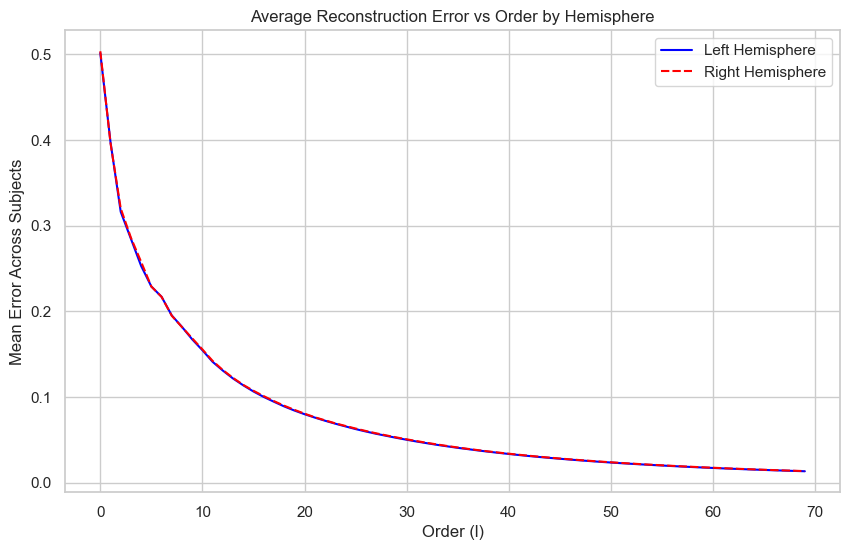

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(data={"Left Hemisphere":all_errors_lh, "Right Hemisphere": all_errors_rh},palette=["blue", "red"])
plt.xlabel('Order (l)')
plt.ylabel('Mean Error Across Subjects')
plt.title('Average Reconstruction Error vs Order by Hemisphere')
plt.grid(True)

#Order from which the reconstruction is satisfying
index_lh = np.where(np.array(all_errors_lh) < 0.1)[0][0] + 1
index_rh = np.where(np.array(all_errors_rh) < 0.1)[0][0] + 1

print(f"Order from which the normalized error is below 0.1:")
print(f"- Left hemisphere: {index_lh}")
print(f"- Right hemisphere: {index_rh}")


In [6]:
#Computation of the vector error for each participant at the maximum order

l=lmax
all_participant_error={"lh":[], "rh":[]}

for folder in os.listdir(main_folder):
    folder_path=os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        # Left hemisphere
        with open(os.path.join(folder_path,"coeffs_lh.pkl"), 'rb') as f:
            coeffs_lh=pickle.load(f)
        coeffs_lh=coeffs_lh['organized_coeffs']
        resampled_data_lh = np.load(os.path.join(folder_path, "lh_resampled.npz"))
        recon_surface_lh = SH.generate_surface(Y, l, 0, coeffs_lh)
        error_lh=np.sqrt(np.sum((recon_surface_lh-resampled_data_lh['coords'])**2, axis=1))
        error_lh = error_lh/np.std(resampled_data_lh['coords'])
        all_participant_error["lh"].append(error_lh)

        # Right hemisphere
        with open(os.path.join(folder_path,"coeffs_rh.pkl"), 'rb') as f:
            coeffs_rh=pickle.load(f)
        coeffs_rh=coeffs_rh['organized_coeffs'] 
        resampled_data_rh = np.load(os.path.join(folder_path, "rh_resampled.npz"))
        recon_surface_rh = SH.generate_surface(Y, l, 0, coeffs_rh)
        error_rh=np.sqrt(np.sum((recon_surface_rh-resampled_data_rh['coords'])**2, axis=1))
        error_rh = error_rh/np.std(resampled_data_rh['coords'])
        all_participant_error["rh"].append(error_rh)

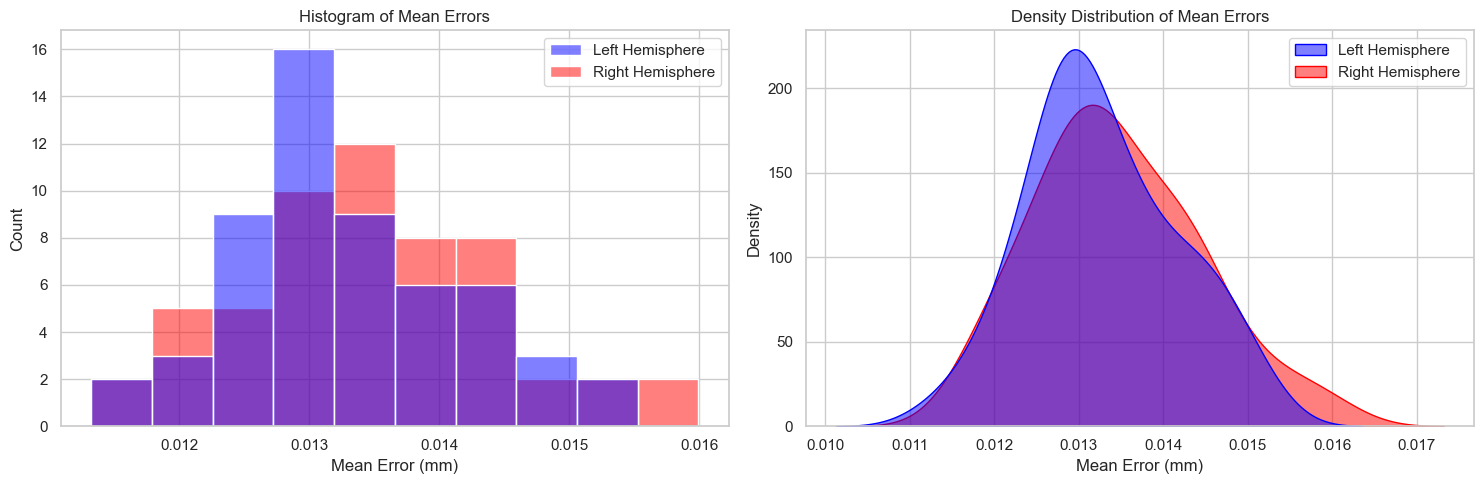


Left Hemisphere Statistics:
Mean: 0.01328
Median: 0.01307
Std: 0.00088
Min: 0.01132
Max: 0.01516

Right Hemisphere Statistics:
Mean: 0.01347
Median: 0.01332
Std: 0.00098
Min: 0.01173
Max: 0.01599


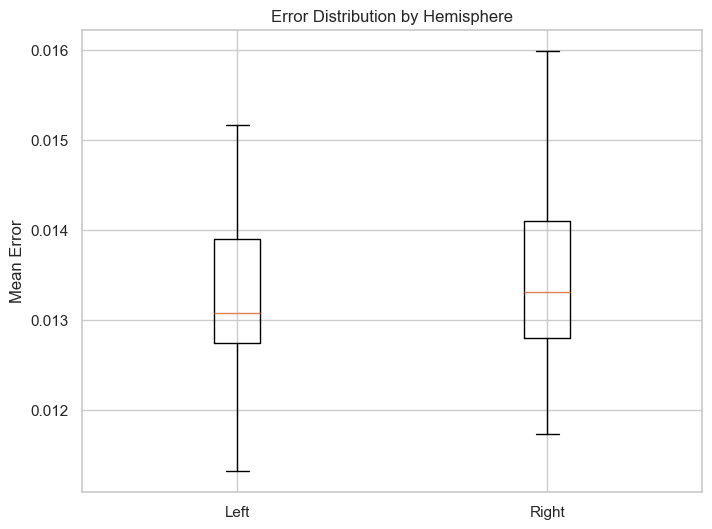

In [7]:
#Mean error for each subject 
all_participant_error_lh=all_participant_error["lh"]
mean_participant_error_lh=[]
for x in all_participant_error_lh:
    mean_participant_error_lh.append(np.mean(x))

all_participant_error_rh=all_participant_error["rh"]
mean_participant_error_rh=[]
for x in all_participant_error_rh:
    mean_participant_error_rh.append(np.mean(x))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram plot
sns.histplot(
    data={
        'Left Hemisphere': mean_participant_error_lh,
        'Right Hemisphere': mean_participant_error_rh
    },
    alpha=0.5,
    palette=['blue', 'red'],
    ax=ax1
)
ax1.set_title('Histogram of Mean Errors')
ax1.set_xlabel('Mean Error (mm)')
ax1.set_ylabel('Count')

# KDE plot
sns.kdeplot(
    data={
        'Left Hemisphere': mean_participant_error_lh,
        'Right Hemisphere': mean_participant_error_rh
    },
    fill=True,
    alpha=0.5,
    palette=['blue', 'red'],
    ax=ax2
)
ax2.set_title('Density Distribution of Mean Errors')
ax2.set_xlabel('Mean Error (mm)')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()

#  Descriptive statistics for each hemisphere
stats_lh = {
    'Mean': np.mean(mean_participant_error_lh),
    'Median': np.median(mean_participant_error_lh),
    'Std': np.std(mean_participant_error_lh),
    'Min': np.min(mean_participant_error_lh),
    'Max': np.max(mean_participant_error_lh)
}

stats_rh = {
    'Mean': np.mean(mean_participant_error_rh),
    'Median': np.median(mean_participant_error_rh),
    'Std': np.std(mean_participant_error_rh),
    'Min': np.min(mean_participant_error_rh),
    'Max': np.max(mean_participant_error_rh)
}

print("\nLeft Hemisphere Statistics:")
for key, value in stats_lh.items():
    print(f"{key}: {value:.5f}")

print("\nRight Hemisphere Statistics:")
for key, value in stats_rh.items():
    print(f"{key}: {value:.5f}")

# Box plot to compare distributions
plt.figure(figsize=(8, 6))
plt.boxplot([mean_participant_error_lh, mean_participant_error_rh], labels=['Left', 'Right'])
plt.title('Error Distribution by Hemisphere')
plt.ylabel('Mean Error')
plt.grid(True)
plt.show()

In [8]:
def compare_original_surfaces(main_folder):

    results = {'lh': [], 'rh': []}
    
    # Initialize one distance matrix per hemisphere
    dist_matrix_lh = np.zeros((n_subjects, n_subjects))
    dist_matrix_rh = np.zeros((n_subjects, n_subjects))
    
    # Lists to store all surfaces before computing distances
    surfaces_lh = []
    surfaces_rh = []
    
    # Load all original surfaces from npz files
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        if os.path.isdir(folder_path):
            # Left hemisphere: load coordinates from npz file
            data_lh = np.load(os.path.join(folder_path, "lh_resampled.npz"))
            coords_lh = data_lh['coords'] 
            surfaces_lh.append(coords_lh)
            
            # Right hemisphere: same process
            data_rh = np.load(os.path.join(folder_path, "rh_resampled.npz"))
            coords_rh = data_rh['coords']
            surfaces_rh.append(coords_rh)
    
    # Convert lists to numpy arrays for efficient computation
    surfaces_lh = np.array(surfaces_lh)  # Shape: (n_subjects, n_vertices, 3)
    surfaces_rh = np.array(surfaces_rh)
    
    # Compute pairwise distances between all subjects
    for i in range(n_subjects):
        for j in range(i+1, n_subjects):
            # Calculate mean Euclidean distance between corresponding vertices
            dist_lh = np.mean(np.sqrt(np.sum((surfaces_lh[i] - surfaces_lh[j])**2, axis=1)))
            dist_rh = np.mean(np.sqrt(np.sum((surfaces_rh[i] - surfaces_rh[j])**2, axis=1)))
            
            dist_matrix_lh[i, j] = dist_lh
            dist_matrix_lh[j, i] = dist_lh
            dist_matrix_rh[i, j] = dist_rh
            dist_matrix_rh[j, i] = dist_rh
    
    results['lh'].append(dist_matrix_lh)
    results['rh'].append(dist_matrix_rh)
    
    return results

In [9]:
from scipy.spatial.distance import pdist, squareform

def compare_reconstructions(main_folder, SH, Y, lmax):
    results = {'lh': [], 'rh': []}
    
    for l in range(lmax + 1):
        # Initialize distance matrices for each hemisphere
        dist_matrix_lh = np.zeros((n_subjects, n_subjects))
        dist_matrix_rh = np.zeros((n_subjects, n_subjects))
        
        # Get all reconstructed surfaces for this order l
        surfaces_lh = []
        surfaces_rh = []
        
        # First, reconstruct all surfaces
        for folder in os.listdir(main_folder):
            folder_path = os.path.join(main_folder, folder)
            if os.path.isdir(folder_path):
                # Left hemisphere
                with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
                    coeffs_lh = pickle.load(f)['organized_coeffs']
                recon_lh = SH.generate_surface(Y, l, 0, coeffs_lh)
                surfaces_lh.append(recon_lh)
                
                # Right hemisphere
                with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
                    coeffs_rh = pickle.load(f)['organized_coeffs']
                recon_rh = SH.generate_surface(Y, l, 0, coeffs_rh)
                surfaces_rh.append(recon_rh)
        
        # Convert to numpy arrays
        surfaces_lh = np.array(surfaces_lh)
        surfaces_rh = np.array(surfaces_rh)
        
        # Calculate pairwise distances
        for i in range(n_subjects):
            for j in range(i+1, n_subjects):
                # Euclidean distance between surfaces
                dist_lh = np.mean(np.sqrt(np.sum((surfaces_lh[i] - surfaces_lh[j])**2, axis=1)))
                dist_rh = np.mean(np.sqrt(np.sum((surfaces_rh[i] - surfaces_rh[j])**2, axis=1)))
                
                dist_matrix_lh[i, j] = dist_lh
                dist_matrix_lh[j, i] = dist_lh
                dist_matrix_rh[i, j] = dist_rh
                dist_matrix_rh[j, i] = dist_rh
        
        results['lh'].append(dist_matrix_lh)
        results['rh'].append(dist_matrix_rh)
    
    return results


In [ ]:
# results_to_save = {
#     'distance_matrices': results,
# }

# with open('surface_comparison_results.pkl', 'wb') as f:
#     pickle.dump(results_to_save, f)

In [10]:
# Load both reconstruction results and original surface comparisons
with open('surface_comparison_results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

# Calculate distances between original surfaces
original_distances = compare_original_surfaces(main_folder)
results = loaded_results['distance_matrices']

# Threshold for the mean reconstruction error compared to the original surface distances
threshold = 0.93

Order from which the mean reconstruction error is above 93.0% of the real one:
Left Hemi: 23
Right Hemi: 23


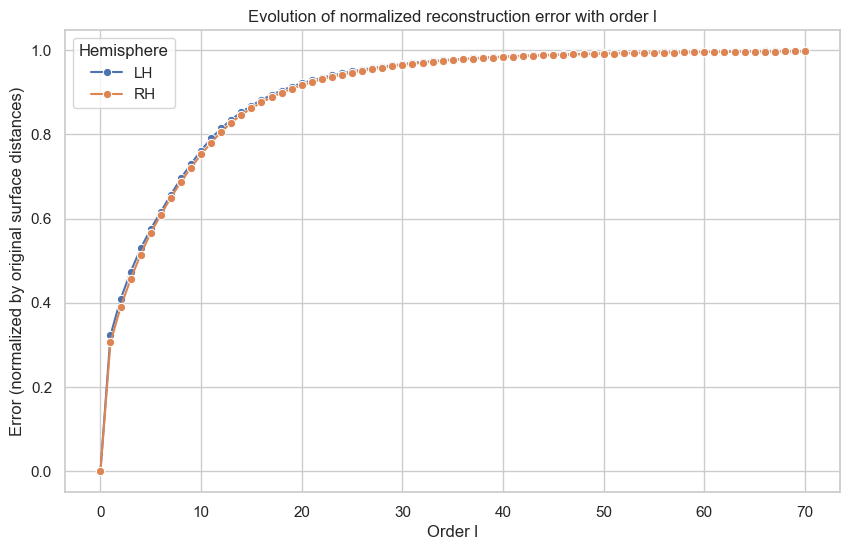

In [11]:
mean_errors = {'lh': [], 'rh': []}

# Calculate baseline errors from original surfaces
baseline_error_lh = np.mean(original_distances['lh'][0][np.triu_indices_from(original_distances['lh'][0], k=1)])
baseline_error_rh = np.mean(original_distances['rh'][0][np.triu_indices_from(original_distances['rh'][0], k=1)])

# Calculate normalized errors for each order l
for l in range(lmax + 1):
    # Normalize by dividing by the baseline error from original surfaces
    error_lh = np.mean(results['lh'][l][np.triu_indices_from(results['lh'][l], k=1)]) / baseline_error_lh
    error_rh = np.mean(results['rh'][l][np.triu_indices_from(results['rh'][l], k=1)]) / baseline_error_rh
    
    mean_errors['lh'].append(error_lh)
    mean_errors['rh'].append(error_rh)

lh_index=np.where(np.array(mean_errors['lh'])>threshold)[0][0]+1
rh_index=np.where(np.array(mean_errors['rh'])>threshold)[0][0]+1

print(f"Order from which the mean reconstruction error is above {threshold*100}% of the real one:")
print(f'Left Hemi: {lh_index}')
print(f'Right Hemi: {rh_index}')

plt.figure(figsize=(10, 6))
sns.lineplot(data={'Order l': list(range(lmax + 1)) * 2,
                  'Normalized Error': mean_errors['lh'] + mean_errors['rh'],
                  'Hemisphere': ['LH'] * len(mean_errors['lh']) + ['RH'] * len(mean_errors['rh'])},
           x='Order l', y='Normalized Error', hue='Hemisphere', marker='o')
plt.title('Evolution of normalized reconstruction error with order l')
plt.ylabel('Error (normalized by original surface distances)')
plt.grid(True)
plt.show()

Deeper study by clustering the vertices based on the error across the subject  

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

all_participant_error_lh = all_participant_error["lh"]
all_participant_error_rh = all_participant_error["rh"]

features_lh = np.array(all_participant_error_lh).T
features_rh = np.array(all_participant_error_rh).T

silhouette_scores_lh = []
silhouette_scores_rh = []

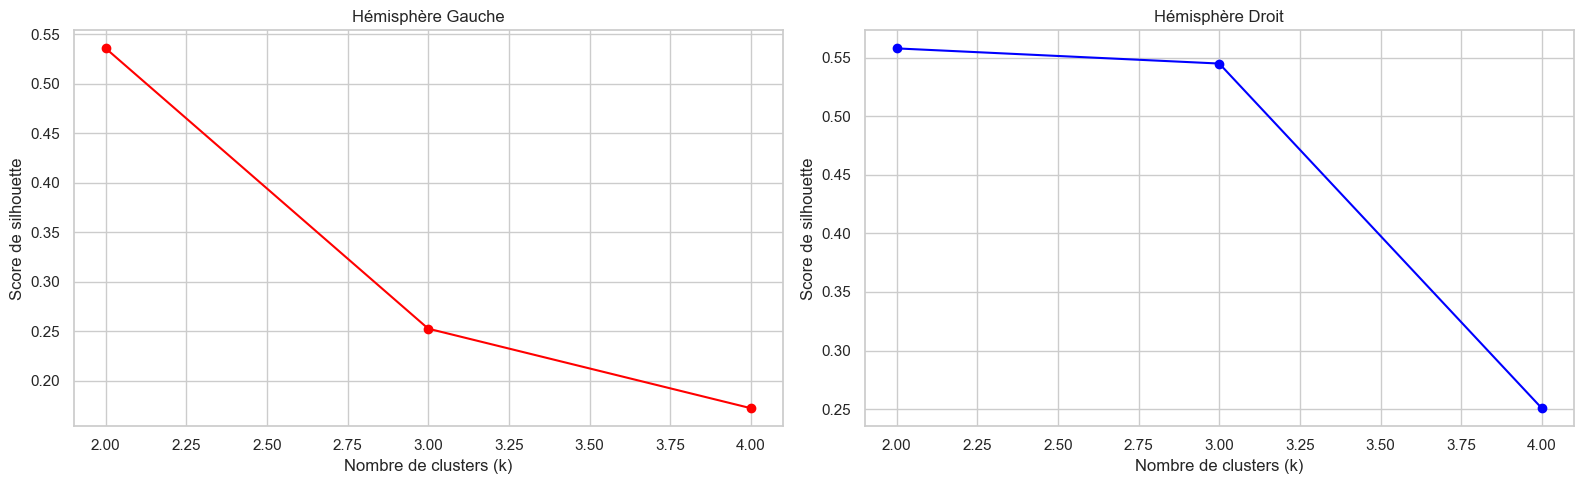

In [13]:
k_range = range(2, 5)

for k in k_range:
    kmeans = KMeans( 
        n_clusters=k,
        init='k-means++',
        n_init=10,         
        random_state=42
    )
    
    labels_lh = kmeans.fit_predict(features_lh)
    labels_rh = kmeans.fit_predict(features_rh)

    silhouette_scores_lh.append(silhouette_score(features_lh, labels_lh))
    silhouette_scores_rh.append(silhouette_score(features_rh, labels_rh))

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores_lh, marker='o', c="red")
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title('Hémisphère Gauche')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores_rh, marker='o', c="blue")
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title('Hémisphère Droit')
plt.grid(True)

plt.tight_layout()  
plt.show()

n_cluster=2 gives the best results by far for both (3 is ok for rh)

In [14]:
n_clusters = 3
kmeans = KMeans(
    n_clusters=n_clusters,
    init='k-means++',
    n_init=10,         
    random_state=42
)

labels_lh = kmeans.fit_predict(features_lh)
labels_rh = kmeans.fit_predict(features_rh)

In [15]:
# Visualization of clustering on 8 randomly selected subjects
folders = os.listdir(main_folder)
rd_folders = rd.sample(folders, 8)

colors = ['red', 'blue', 'green']
p = pv.Plotter(shape=(4, 4))

for idx, folder in enumerate(rd_folders):
   folder_path = os.path.join(main_folder, folder)
   
   # Load data
   with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
       coeffs_lh = pickle.load(f)["organized_coeffs"]
   with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
       coeffs_rh = pickle.load(f)["organized_coeffs"]
   
   resampled_data_lh = np.load(os.path.join(folder_path, "lh_resampled.npz"))
   resampled_data_rh = np.load(os.path.join(folder_path, "rh_resampled.npz"))
   recon_surface_lh = SH.generate_surface(Y, l, 0, coeffs_lh)
   recon_surface_rh = SH.generate_surface(Y, l, 0, coeffs_rh)
   
   row = idx // 2
   col = (idx % 2) * 2

   # Plot left hemisphere
   p.subplot(row, col)
   mesh_lh = pv.PolyData(recon_surface_lh, convert_triangles_to_pyvista(resampled_data_lh["tris"]))
   p.add_mesh(mesh_lh, color='grey', show_edges=True, opacity=0.7)
   for cluster_id in range(n_clusters):
       cluster_points = recon_surface_lh[labels_lh == cluster_id]
       point_cloud = pv.PolyData(cluster_points)
       p.add_mesh(point_cloud, color=colors[cluster_id], point_size=10, render_points_as_spheres=True)
   p.add_text(f"LH{idx+1}", font_size=8, position='upper_edge')

   # Plot right hemisphere
   p.subplot(row, col + 1)
   mesh_rh = pv.PolyData(recon_surface_rh, convert_triangles_to_pyvista(resampled_data_rh["tris"]))
   p.add_mesh(mesh_rh, color='grey', show_edges=True, opacity=0.7)
   for cluster_id in range(n_clusters):
       cluster_points = recon_surface_rh[labels_rh == cluster_id]
       point_cloud = pv.PolyData(cluster_points)
       p.add_mesh(point_cloud, color=colors[cluster_id], point_size=10, render_points_as_spheres=True)
   p.add_text(f"RH{idx+1}", font_size=8 , position='upper_edge')

p.show()

Widget(value='<iframe src="http://localhost:53803/index.html?ui=P_0x2a8821c44d0_0&reconnect=auto" class="pyvis…

Study on the properties of the coefficients

In [17]:
#Load the coeffs
coeffs_all_lh = {}
coeffs_all_rh = {}
for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
            coeffs_lh = pickle.load(f)
        coeffs_all_lh[folder] =  coeffs_lh["organized_coeffs"]
        with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
            coeffs_rh = pickle.load(f)
        coeffs_all_rh[folder] =  coeffs_rh["organized_coeffs"]

In [30]:
def plot_coeffs_distribution(coeffs_all, l_value):
    coeffs_x = []
    coeffs_y = []
    coeffs_z = []
    
    for subject in coeffs_all:
        for m in range(-l_value, l_value + 1):
            vector = coeffs_all[subject][l_value][m]
            coeffs_x.append(vector[0])
            coeffs_y.append(vector[1])
            coeffs_z.append(vector[2])
    
    coeffs_x = np.array(coeffs_x)
    coeffs_y = np.array(coeffs_y)
    coeffs_z = np.array(coeffs_z)
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    colors = ['red', 'green', 'blue']
    cmaps = ['Reds', 'Greens', 'Blues']
    components = [(coeffs_x, 'X'), (coeffs_y, 'Y'), (coeffs_z, 'Z')]
    
    for i, (coeffs, comp_name) in enumerate(components):
        ax1, ax2, ax3, ax4 = axes[i]
        
        sns.kdeplot(x=coeffs.real, y=coeffs.imag, ax=ax1, cmap=cmaps[i], fill=True)
        ax1.scatter(coeffs.real, coeffs.imag, alpha=0.2, color=colors[i], label=f'{comp_name}-component')
        ax1.set_title(f'{comp_name}-component: Complex plane (l={l_value})')
        ax1.set_xlabel('Real part')
        ax1.set_ylabel('Imaginary part')
        ax1.grid(True)
        ax1.legend()
        
        sns.histplot(data=np.abs(coeffs), ax=ax2, kde=True, color=colors[i])
        ax2.set_title(f'{comp_name}-component: Magnitude')
        ax2.set_xlabel('|coefficient|')
        
        sns.histplot(data=coeffs.real, ax=ax3, kde=True, color=colors[i])
        ax3.set_title(f'{comp_name}-component: Real part')
        ax3.set_xlabel('Re(coefficient)')
        
        sns.histplot(data=coeffs.imag, ax=ax4, kde=True, color=colors[i])
        ax4.set_title(f'{comp_name}-component: Imaginary part')
        ax4.set_xlabel('Im(coefficient)')
    
    plt.tight_layout()
    return fig

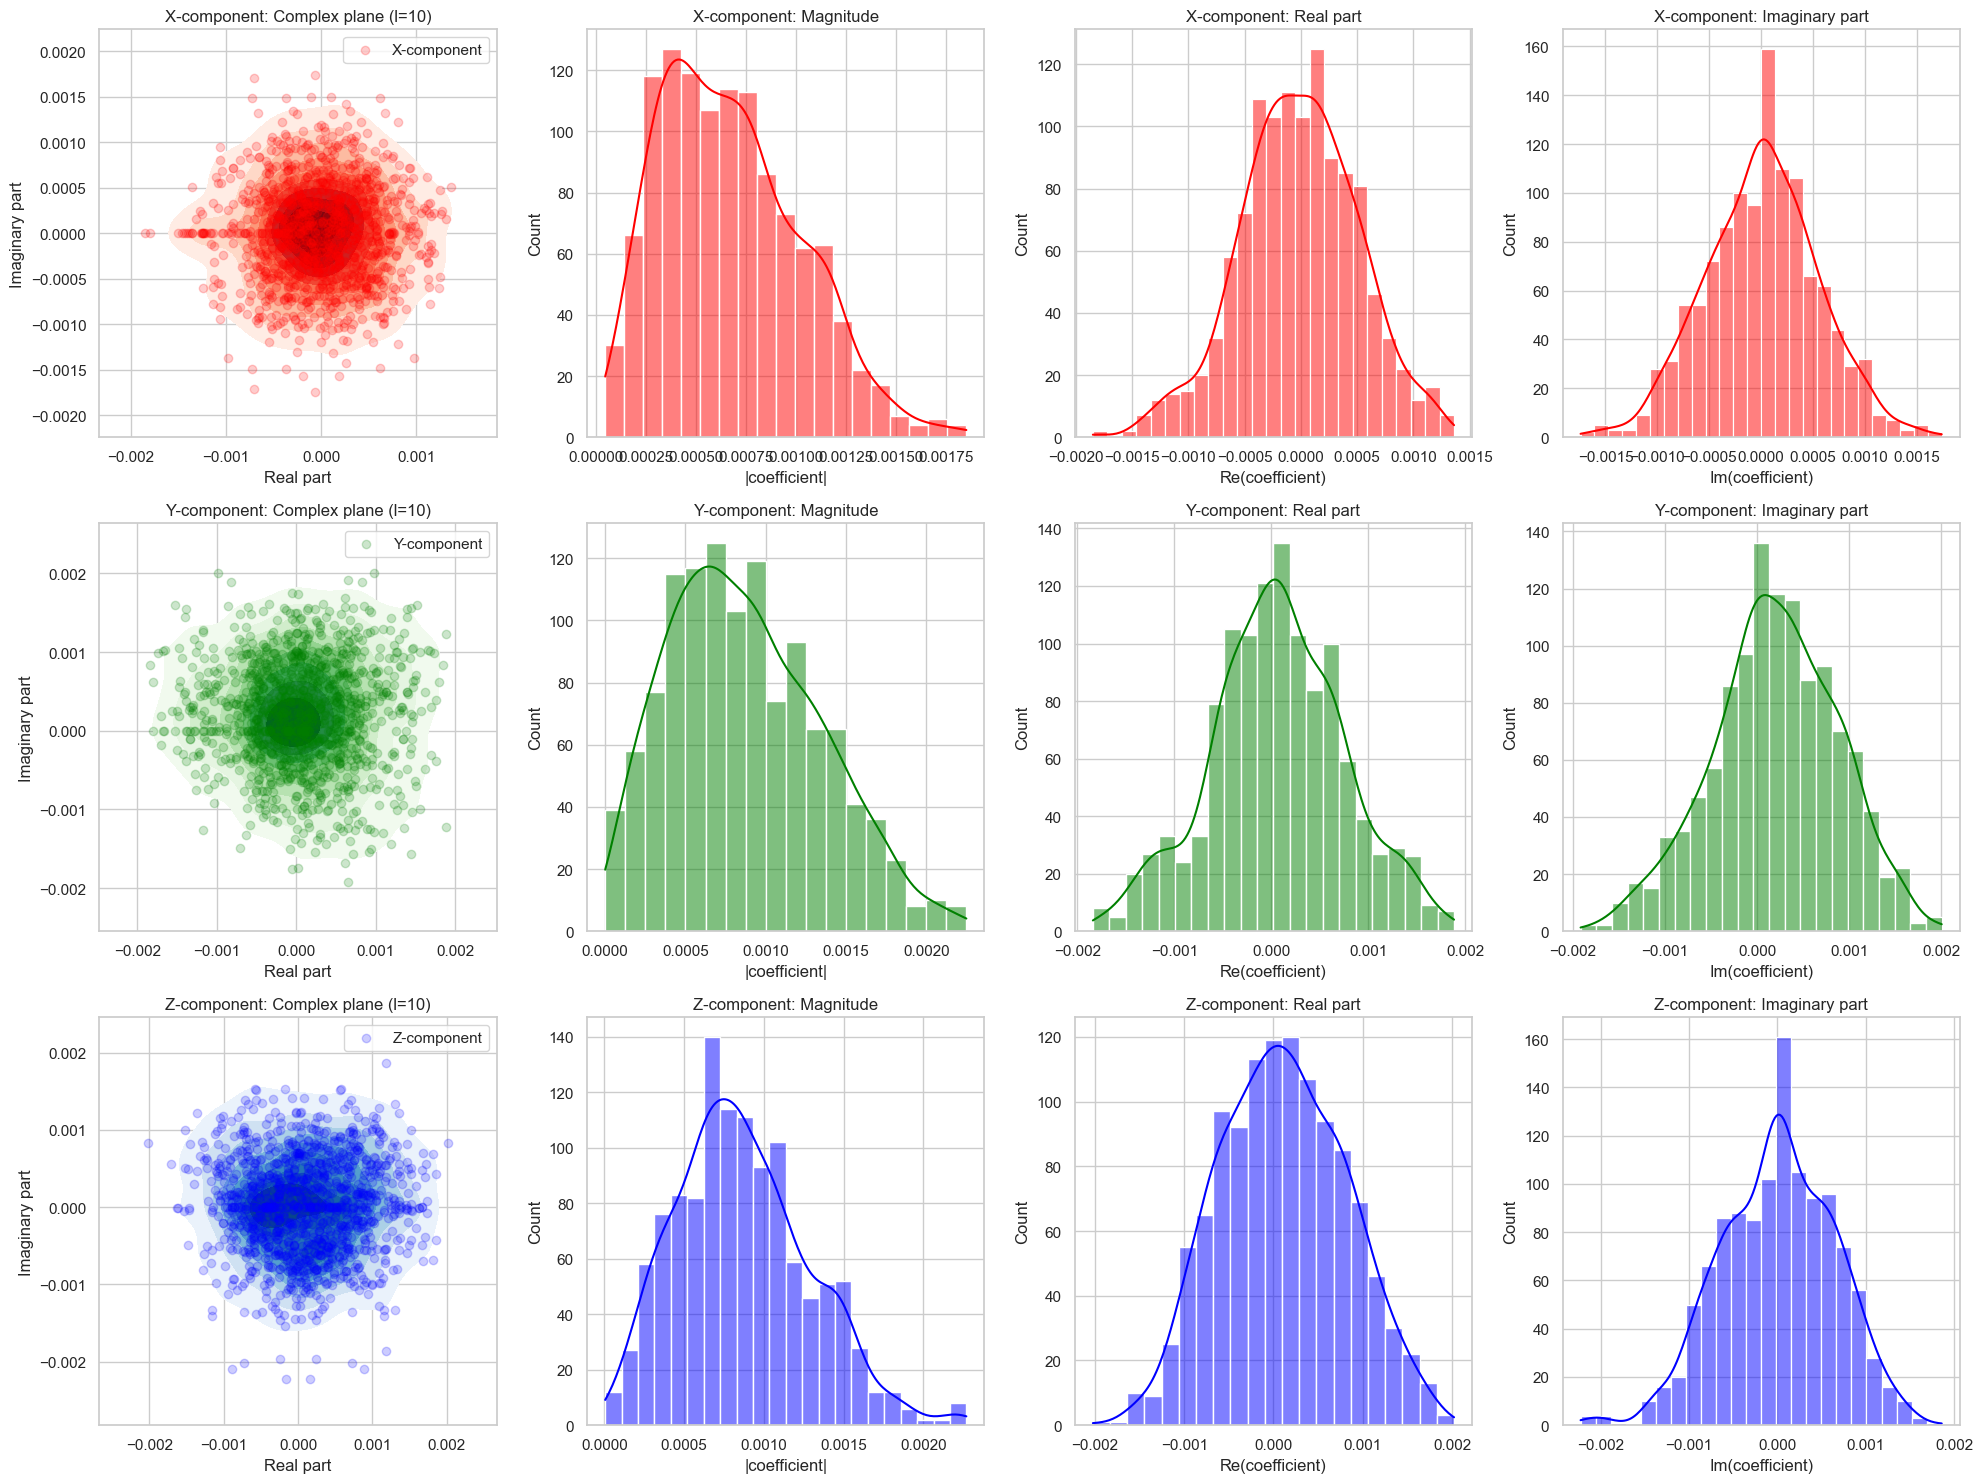

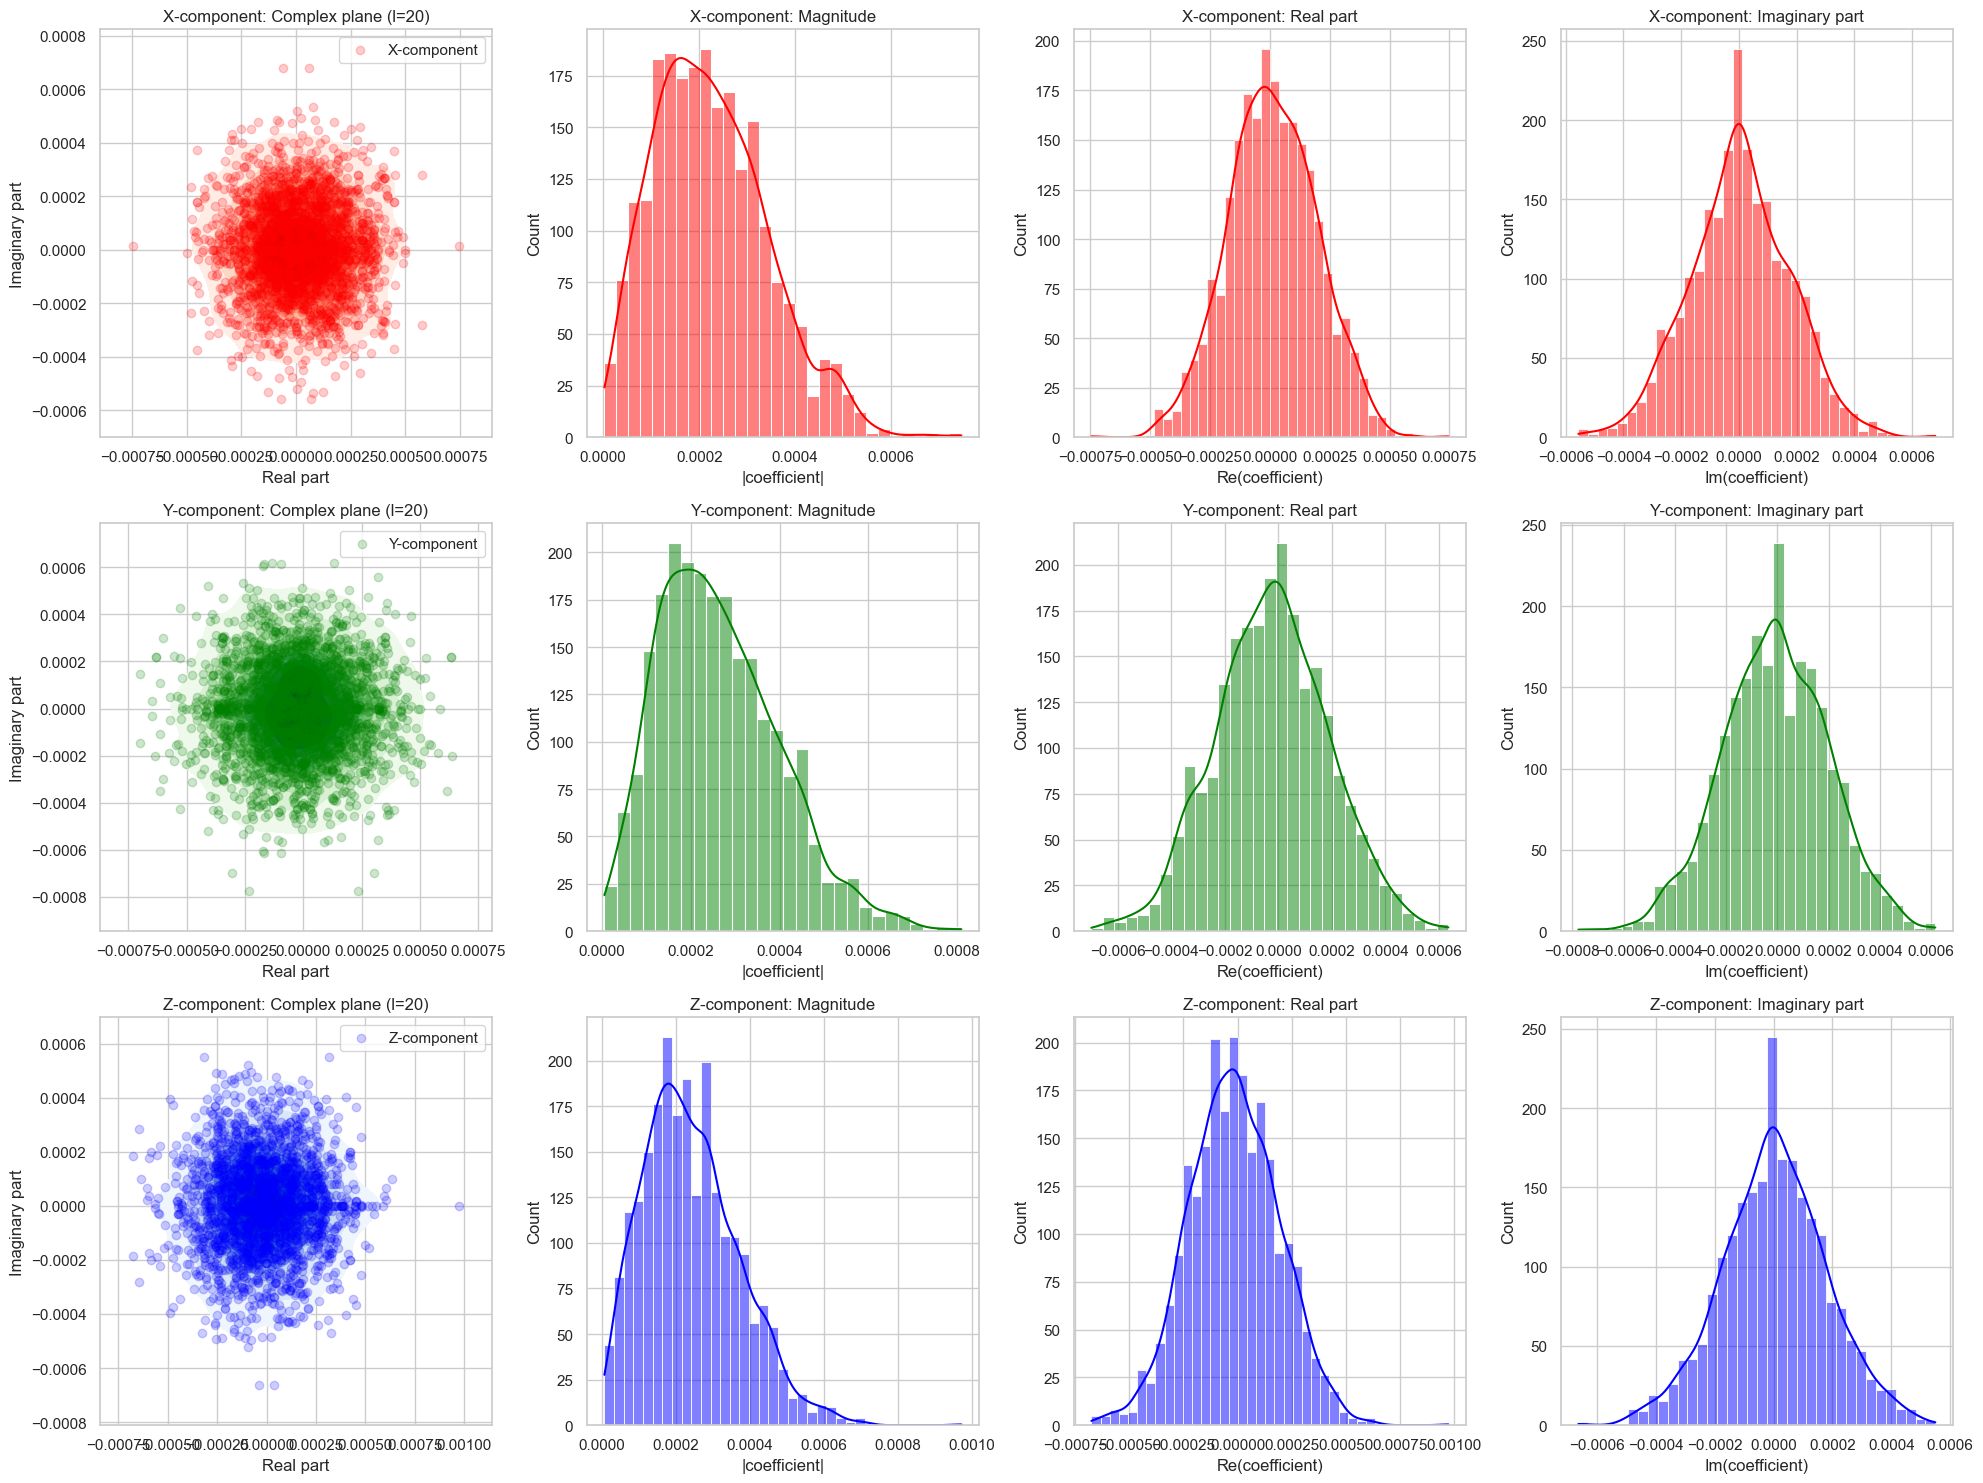

In [32]:
fig = plot_coeffs_distribution(coeffs_all_lh, 10)
fig = plot_coeffs_distribution(coeffs_all_rh, 20)
plt.show()
plt.close()

In [33]:
#Utils 

def change_representations(coeffs_dic):
    lmax=coeffs_dic["lmax"]
    coeffs=coeffs_dic["organized_coeffs"]
    a = {l: [] for l in range(lmax+1)}
    b = {l: [] for l in range(lmax+1)}
    for l in range(lmax+1):
        a[l].append(coeffs[l][l].real)  
        b[l].append(np.array([0.,0.,0.]))  
        for m in range(1, l+1):
            # For C_lm : index l+m
            # For C_l(-m) : index l-m
            a[l].append(coeffs[l][l+m].real + ((-1)**m)*coeffs[l][l-m].real)
            b[l].append(((-1)**m)*coeffs[l][l-m].imag - coeffs[l][l+m].imag)
    return a, b

def spectral_power_order(a, b, l):
    return np.sum(np.array(a[l])**2 + np.array(b[l])**2, axis=0)

def spectral_power_coords(a,b,lmax):
    s_p=np.sum(np.array([spectral_power_order(a,b,l) for l in range(lmax+1)]), axis=0)
    return s_p

def spectral_power_total(a,b,lmax):
    s_p=spectral_power_coords(a,b,lmax)
    return np.sum(s_p)

def correlation_order(u,v,l):
    a_u,b_u = u
    a_v,b_v = v
    return np.sum(np.array(a_u[l])*np.array(a_v[l])+(np.array(b_u[l])*np.array(b_v[l])),axis=0)

def correlation_coords(u,v,lmax):
     c_c=np.sum(np.array([correlation_order(u,v,l) for l in range(lmax+1)]), axis=0)
     return c_c

def correlation_total(u,v,lmax):  
    return np.sum(correlation_coords(u,v,lmax))

In [133]:
#Check of the validity of the change of representation for a subject

subj_coeffs = r'C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN\sub-CC110033\coeffs_lh.pkl'
with open(subj_coeffs, 'rb') as f:
    coeffs_lh = pickle.load(f)

a,b=change_representations(coeffs_lh)

from scipy.special import sph_harm

def reconstruct_surface(a, b, theta, phi, lmax):
   surface = np.zeros((len(theta), 3), dtype=float)
   
   for l in range(lmax+1):
       P_l0 = sph_harm(0, l, theta, phi)
       surface += np.outer(P_l0.real, a[l][0])  
       for m in range(1, l+1):
           P_lm = sph_harm(m, l, theta, phi)
           surface +=  np.outer(P_lm.real, a[l][m]) + np.outer(P_lm.imag, b[l][m]) 
   
   return surface

theta=template_projection['theta']
phi=template_projection['phi']

coords=reconstruct_surface(a,b,theta,phi,lmax)

tris=convert_triangles_to_pyvista(template_projection["sphere_tris"])
p=pv.Plotter()
mesh=pv.PolyData(coords,tris)
p.add_mesh(mesh)
p.show()

Widget(value='<iframe src="http://localhost:48708/index.html?ui=P_0x1cbb9ab7800_4&reconnect=auto" class="pyvis…

In [35]:
coeffs_ab = {}

for folder in os.listdir(main_folder):
   folder_path = os.path.join(main_folder, folder)
   if os.path.isdir(folder_path):
       with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
           coeffs_lh = pickle.load(f)
       with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
           coeffs_rh = pickle.load(f)
       coeffs_ab[folder] = {
           'lh': change_representations(coeffs_lh),
           'rh': change_representations(coeffs_rh)
       }

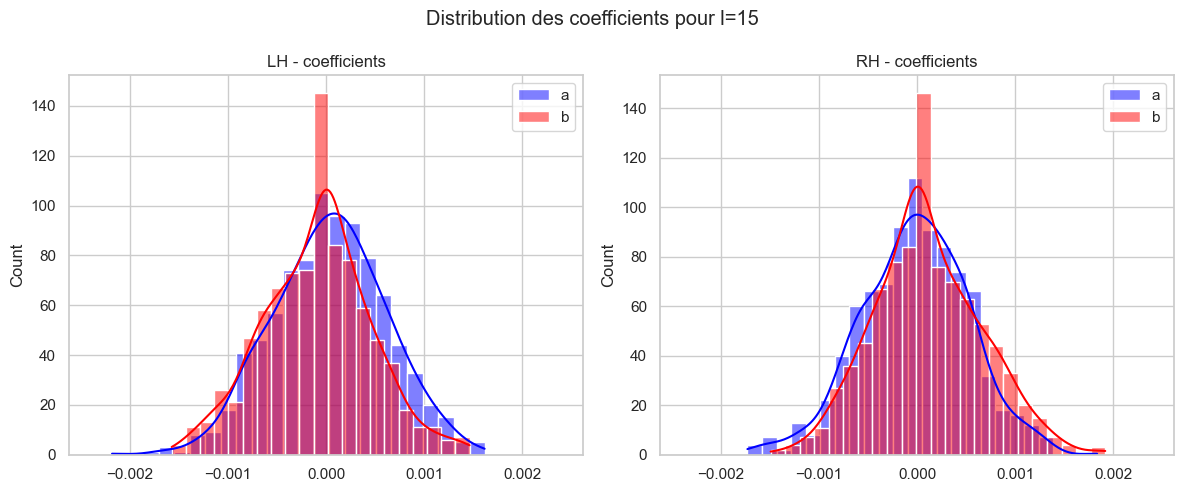

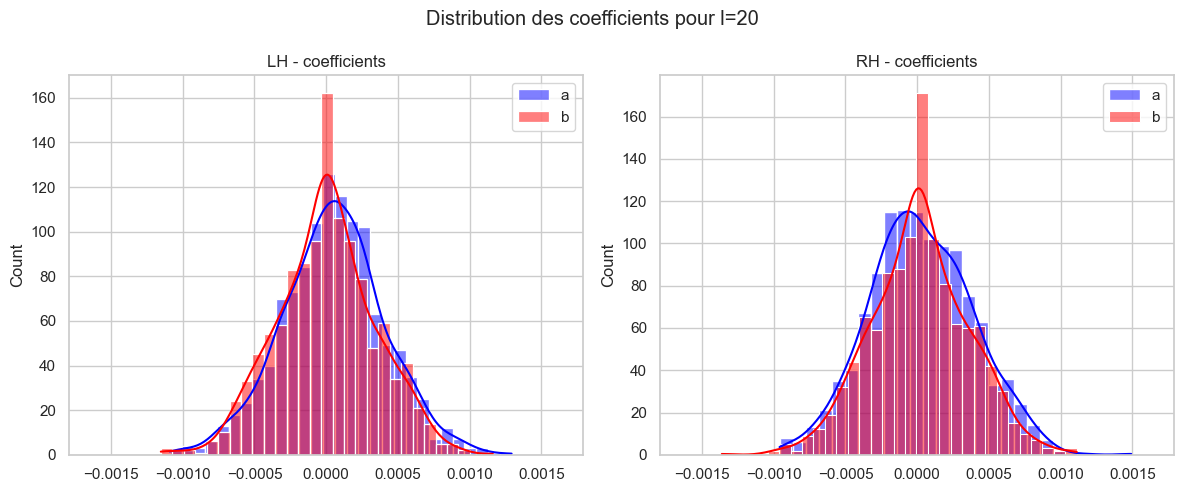

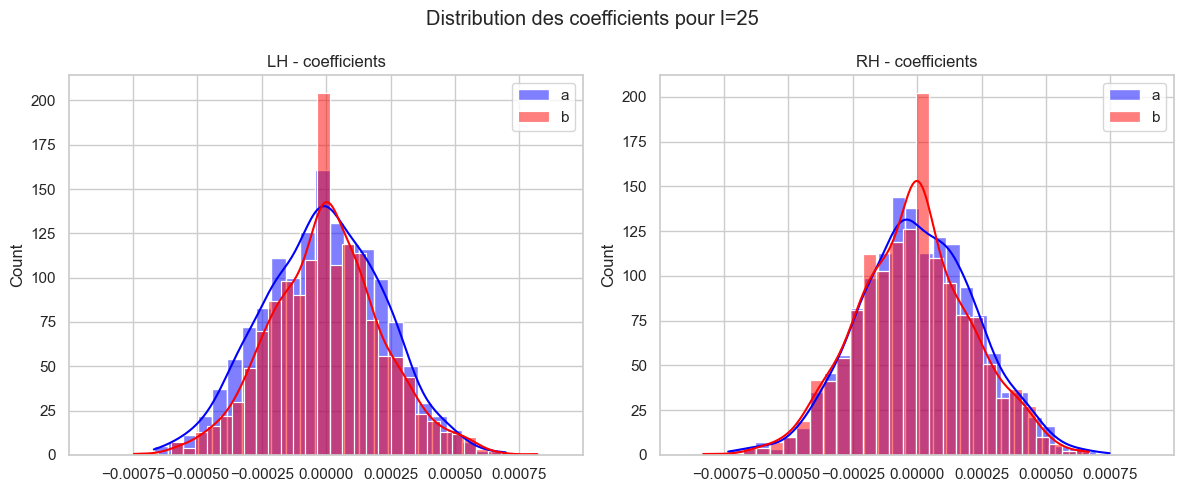

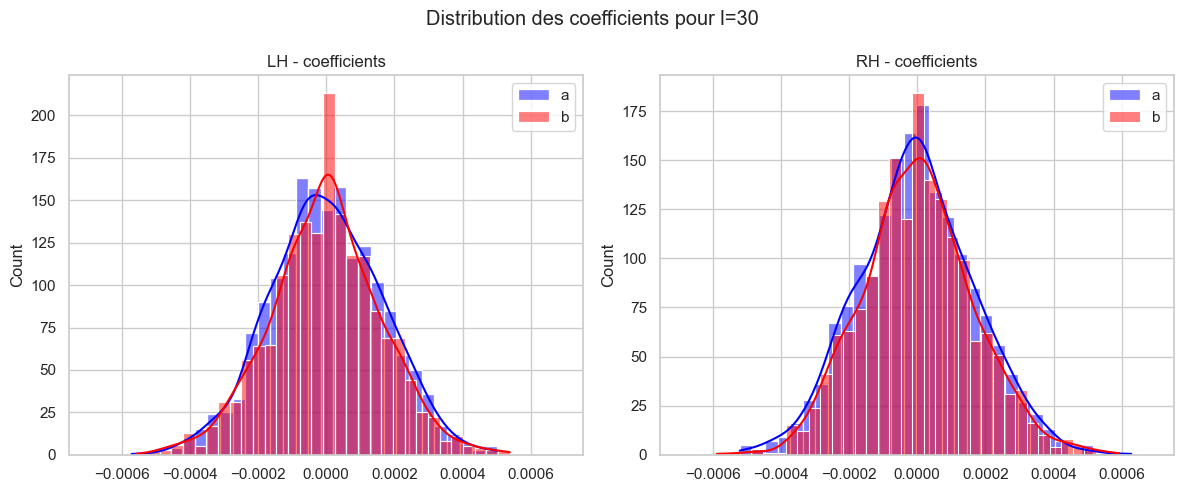

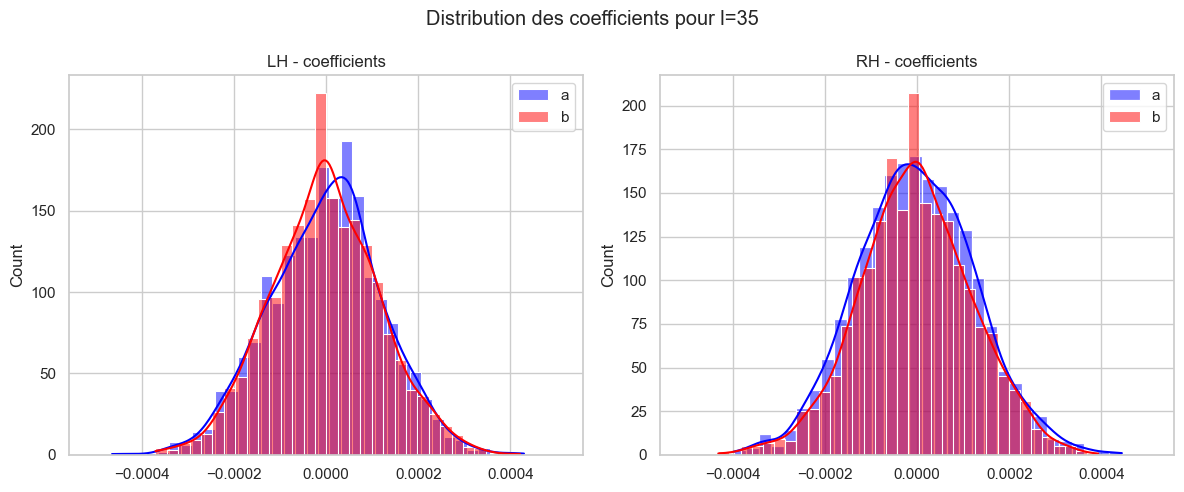

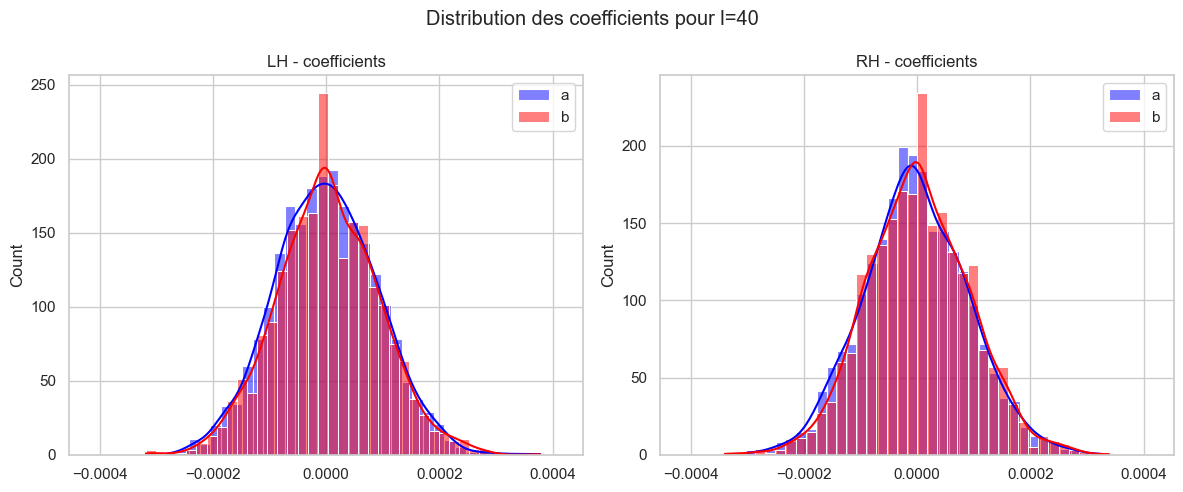

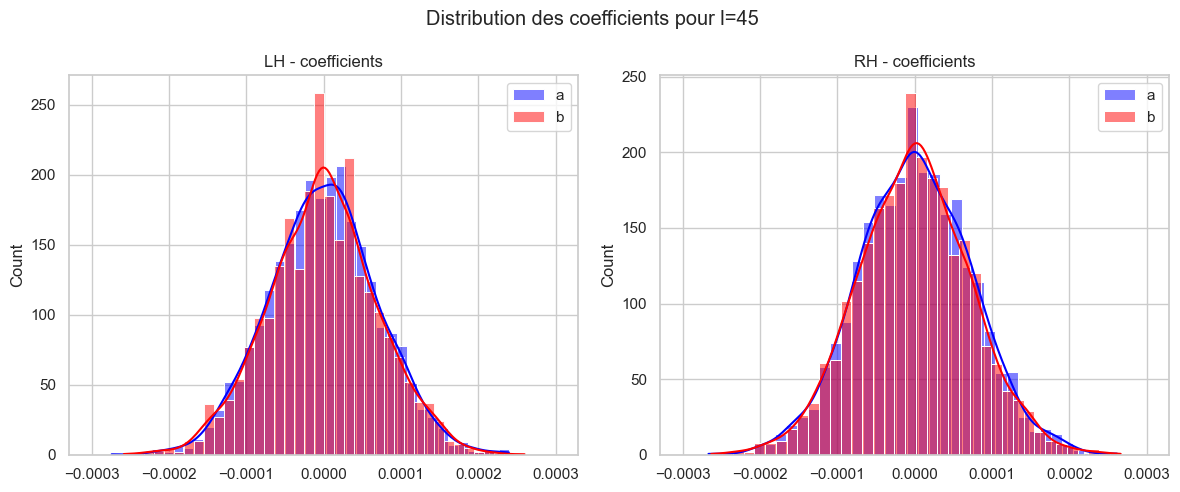

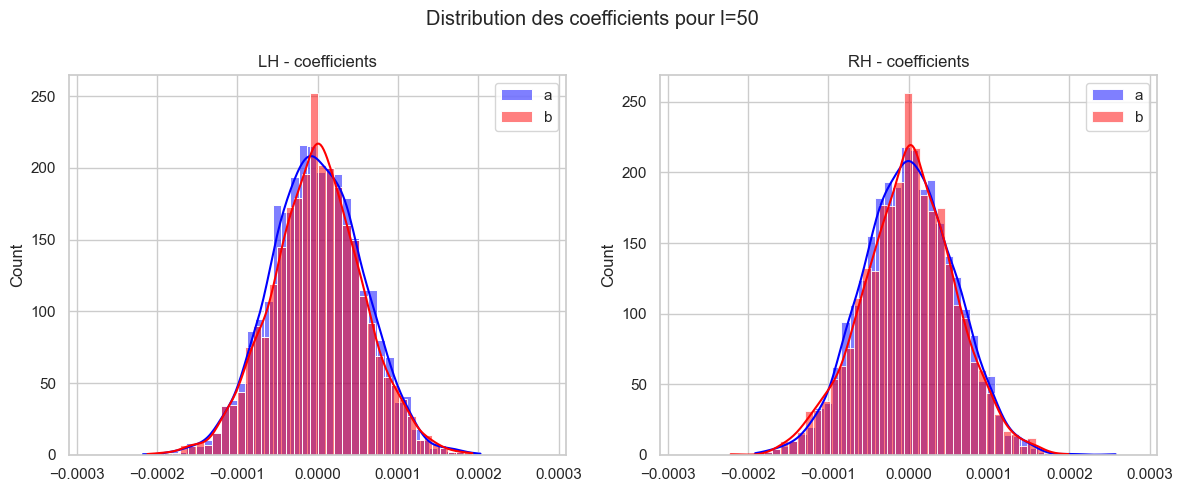

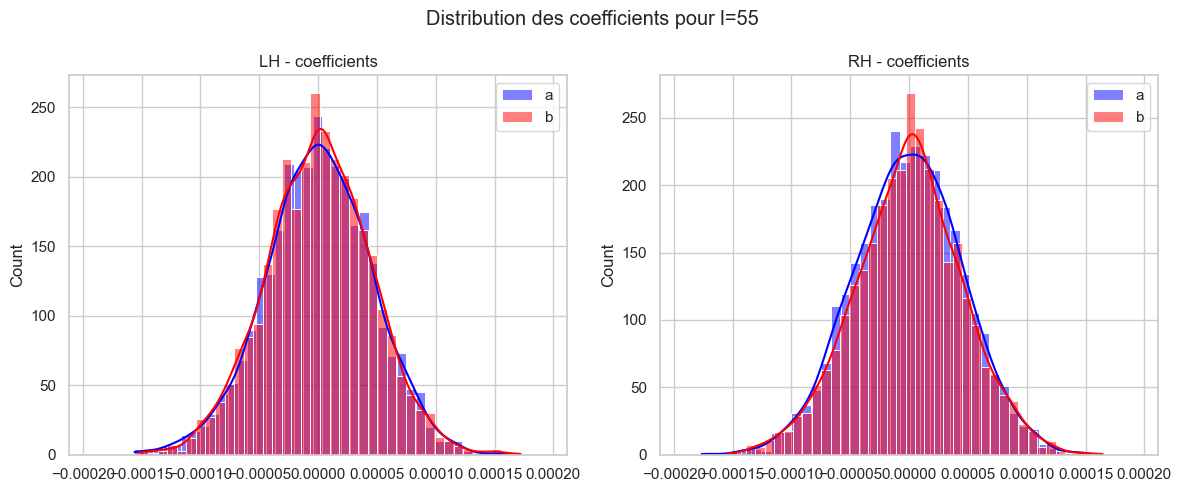

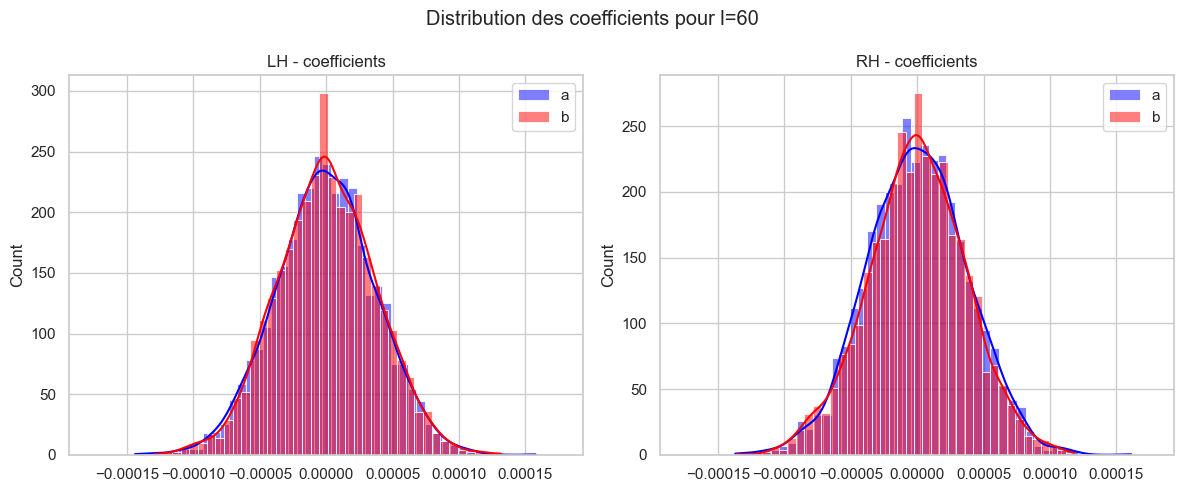

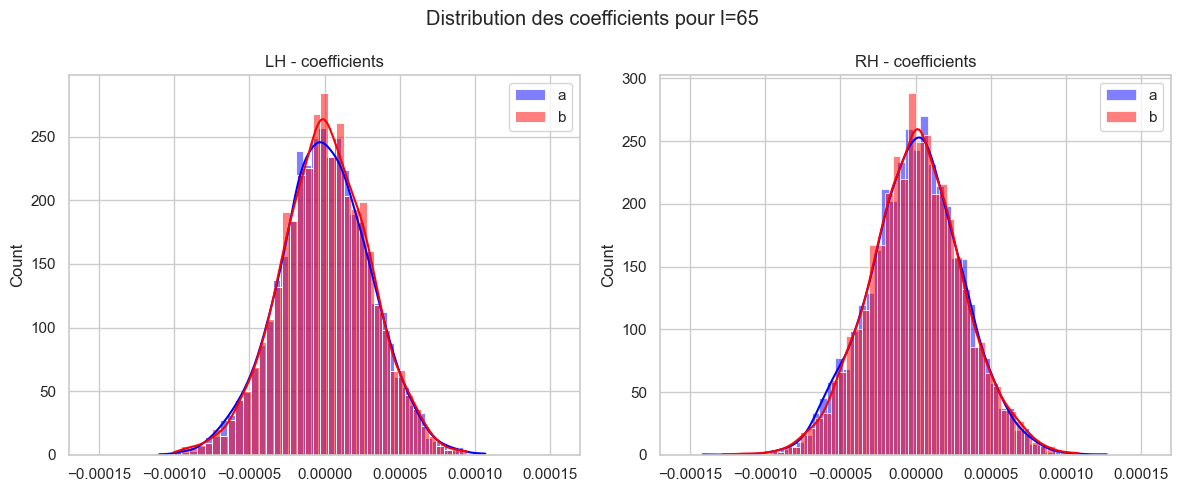

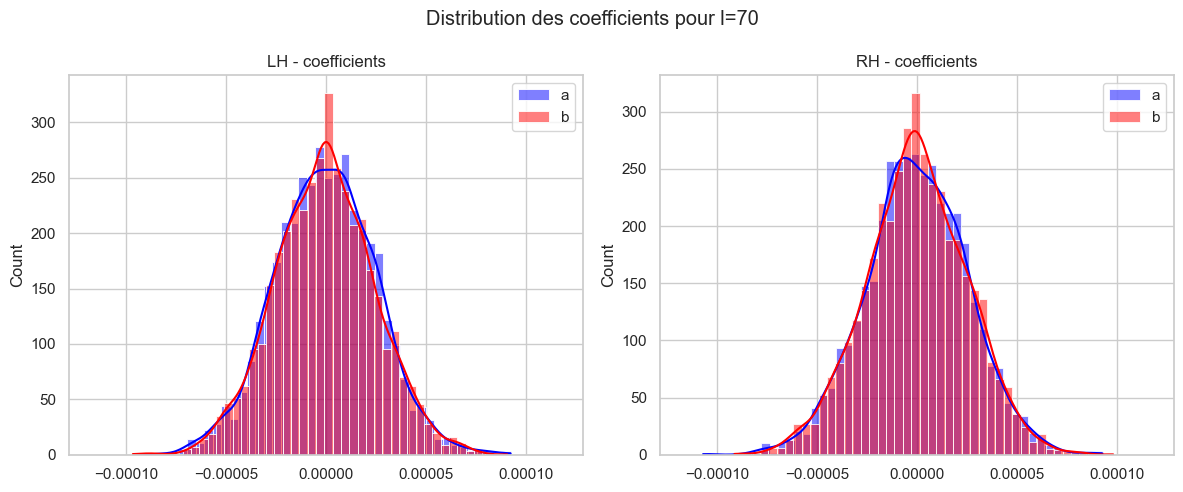

In [36]:
lmin=15

for l in range(lmin, 71, 5):
   alh = [np.array(coeffs_ab[x]['lh'][0][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   blh = [np.array(coeffs_ab[x]['lh'][1][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   arh = [np.array(coeffs_ab[x]['rh'][0][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   brh = [np.array(coeffs_ab[x]['rh'][1][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]

   max_val = max([max(abs(np.array(alh))), max(abs(np.array(blh))), 
                 max(abs(np.array(arh))), max(abs(np.array(brh)))])
   limit = max_val * 1.2

   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
   fig.suptitle(f'Distribution des coefficients pour l={l}')

   sns.histplot(data=alh, ax=ax1, color='blue', alpha=0.5, label='a', kde=True)
   sns.histplot(data=blh, ax=ax1, color='red', alpha=0.5, label='b', kde=True)
   ax1.set_title('LH - coefficients')
   ax1.set_xlim(-limit, limit)
   ax1.legend()

   sns.histplot(data=arh, ax=ax2, color='blue', alpha=0.5, label='a', kde=True)
   sns.histplot(data=brh, ax=ax2, color='red', alpha=0.5, label='b', kde=True)
   ax2.set_title('RH - coefficients')
   ax2.set_xlim(-limit, limit)
   ax2.legend()

   plt.tight_layout()
   plt.show()

Analysis from a spectrum point of view 

In [37]:
powers_lh = {l: [] for l in range(lmax+1)}
powers_rh = {l: [] for l in range(lmax+1)}

for participant in coeffs_ab:
    for l in range(lmax+1):
        powers_lh[l].append(spectral_power_order(coeffs_ab[participant]['lh'][0], coeffs_ab[participant]['lh'][1], l))
        powers_rh[l].append(spectral_power_order(coeffs_ab[participant]['rh'][0], coeffs_ab[participant]['rh'][1], l))

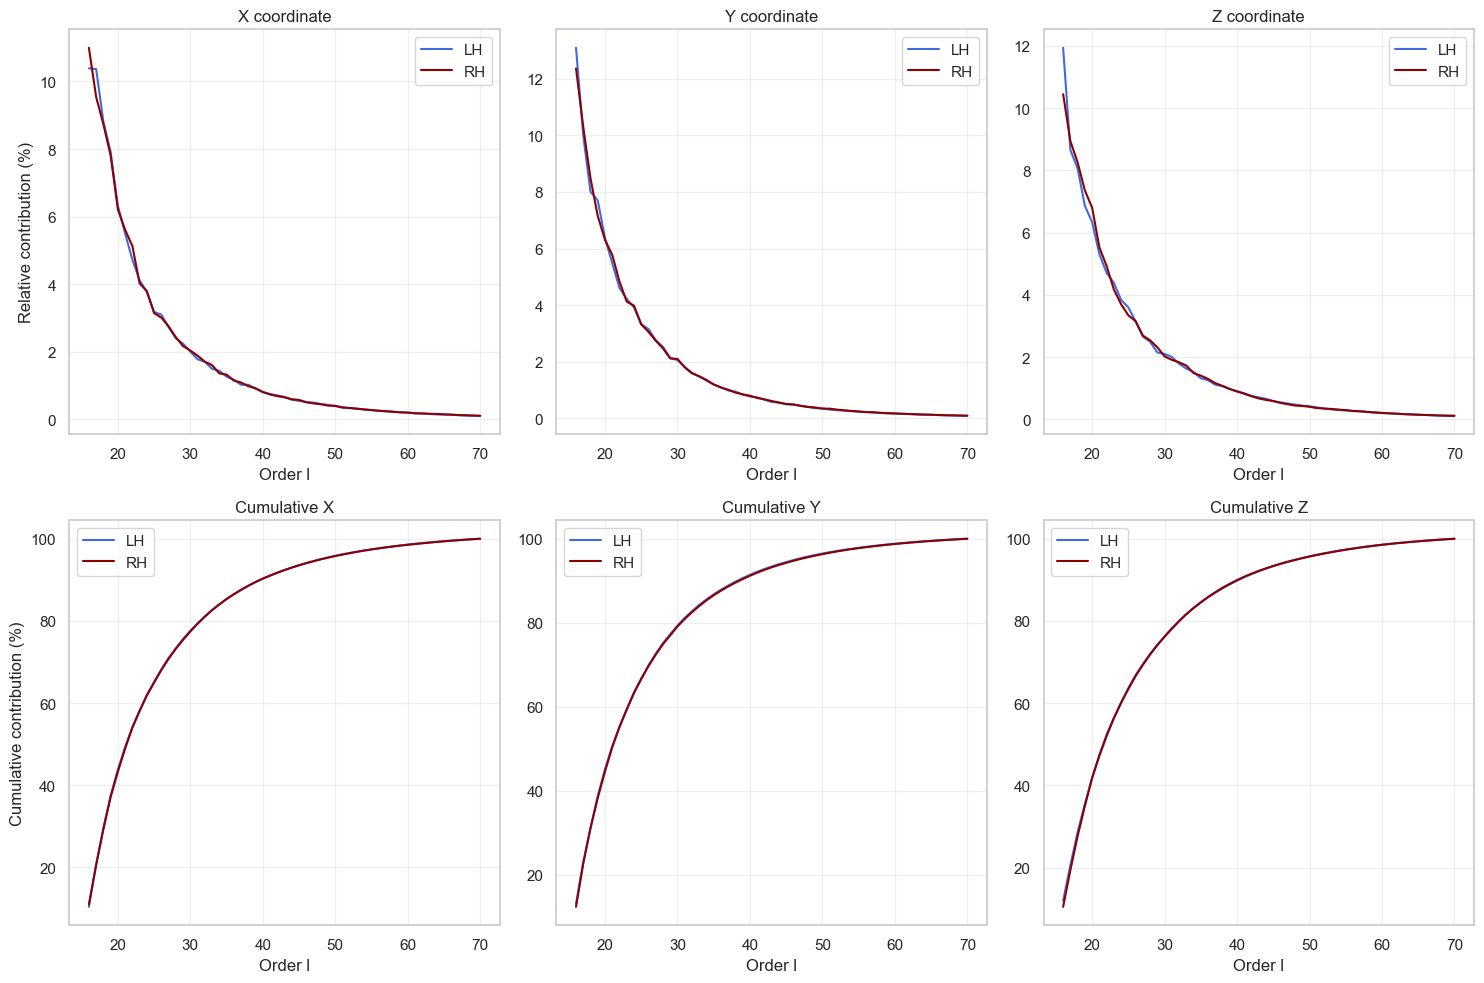

In [38]:
lmin = 16
mean_power_lh = []
mean_power_rh = []
cumsum_power_lh = []
cumsum_power_rh = []

for l in range(lmin, lmax+1):
   mean_power_lh.append(np.mean(np.array(powers_lh[l]), axis=0))
   mean_power_rh.append(np.mean(np.array(powers_rh[l]), axis=0))
   
   if l == lmin:
       cumsum_power_lh.append(mean_power_lh[-1])
       cumsum_power_rh.append(mean_power_rh[-1])
   else:
       cumsum_power_lh.append(cumsum_power_lh[-1] + mean_power_lh[-1])
       cumsum_power_rh.append(cumsum_power_rh[-1] + mean_power_rh[-1])

cumsum_power_lh = np.array(cumsum_power_lh)
cumsum_power_rh = np.array(cumsum_power_rh)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

ax1.plot(range(lmin,lmax+1), 100*np.array(mean_power_lh).T[0]/np.sum(np.array(mean_power_lh).T[0]), 'royalblue', label="LH")
ax1.plot(range(lmin,lmax+1), 100*np.array(mean_power_rh).T[0]/np.sum(np.array(mean_power_rh).T[0]), 'darkred', label="RH")
ax1.set_title('X coordinate')
ax1.set_xlabel('Order l')
ax1.set_ylabel('Relative contribution (%)')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(range(lmin,lmax+1), 100*np.array(mean_power_lh).T[1]/np.sum(np.array(mean_power_lh).T[1]), 'royalblue', label="LH") 
ax2.plot(range(lmin,lmax+1), 100*np.array(mean_power_rh).T[1]/np.sum(np.array(mean_power_rh).T[1]), 'darkred', label="RH")
ax2.set_title('Y coordinate')
ax2.set_xlabel('Order l')
ax2.grid(True, alpha=0.3)
ax2.legend()

ax3.plot(range(lmin,lmax+1), 100*np.array(mean_power_lh).T[2]/np.sum(np.array(mean_power_lh).T[2]), 'royalblue', label="LH")
ax3.plot(range(lmin,lmax+1), 100*np.array(mean_power_rh).T[2]/np.sum(np.array(mean_power_rh).T[2]), 'darkred', label="RH") 
ax3.set_title('Z coordinate')
ax3.set_xlabel('Order l')
ax3.grid(True, alpha=0.3)
ax3.legend()

ax4.plot(range(lmin,lmax+1), 100*cumsum_power_lh.T[0]/np.sum(np.array(mean_power_lh).T[0]), 'royalblue', label="LH")
ax4.plot(range(lmin,lmax+1), 100*cumsum_power_rh.T[0]/np.sum(np.array(mean_power_rh).T[0]), 'darkred', label="RH")
ax4.set_title('Cumulative X')
ax4.set_xlabel('Order l')
ax4.set_ylabel('Cumulative contribution (%)')
ax4.grid(True, alpha=0.3)
ax4.legend()

ax5.plot(range(lmin,lmax+1), 100*cumsum_power_lh.T[1]/np.sum(np.array(mean_power_lh).T[1]), 'royalblue', label="LH")
ax5.plot(range(lmin,lmax+1), 100*cumsum_power_rh.T[1]/np.sum(np.array(mean_power_rh).T[1]), 'darkred', label="RH")
ax5.set_title('Cumulative Y') 
ax5.set_xlabel('Order l')
ax5.grid(True, alpha=0.3)
ax5.legend()

ax6.plot(range(lmin,lmax+1), 100*cumsum_power_lh.T[2]/np.sum(np.array(mean_power_lh).T[2]), 'royalblue', label="LH")
ax6.plot(range(lmin,lmax+1), 100*cumsum_power_rh.T[2]/np.sum(np.array(mean_power_rh).T[2]), 'darkred', label="RH")
ax6.set_title('Cumulative Z')
ax6.set_xlabel('Order l')
ax6.grid(True, alpha=0.3)
ax6.legend()

plt.tight_layout()
plt.show()

Study of the correlation

In [41]:
correlations = {l: [] for l in range(lmax+1)}

# For each pair of participants
for i, participant1 in enumerate(coeffs_ab):
   for j, participant2 in enumerate(coeffs_ab):
       if i < j:
           for l in range(lmax+1):
               corr_lh = correlation_order(
                   (coeffs_ab[participant1]['lh'][0], coeffs_ab[participant1]['lh'][1]),
                   (coeffs_ab[participant2]['lh'][0], coeffs_ab[participant2]['lh'][1]),
                   l
               )

               norm = np.sqrt(powers_lh[l][i] * powers_lh[l][j])
               correlations[l].append(corr_lh/norm)

In [42]:
mean_correlations=[np.mean(correlations[l],axis=0) for l in range(1,lmax+1)]
mean_correlations = np.array(mean_correlations)

for i in range(mean_correlations[0].shape[0]):
    comp_corr = mean_correlations.T[i]
    l_threshold = [l+1 for l,c in enumerate(comp_corr) if c < 0.1][0]
    print(f"Composante {i}: l={l_threshold}")

Composante 0: l=23
Composante 1: l=23
Composante 2: l=18


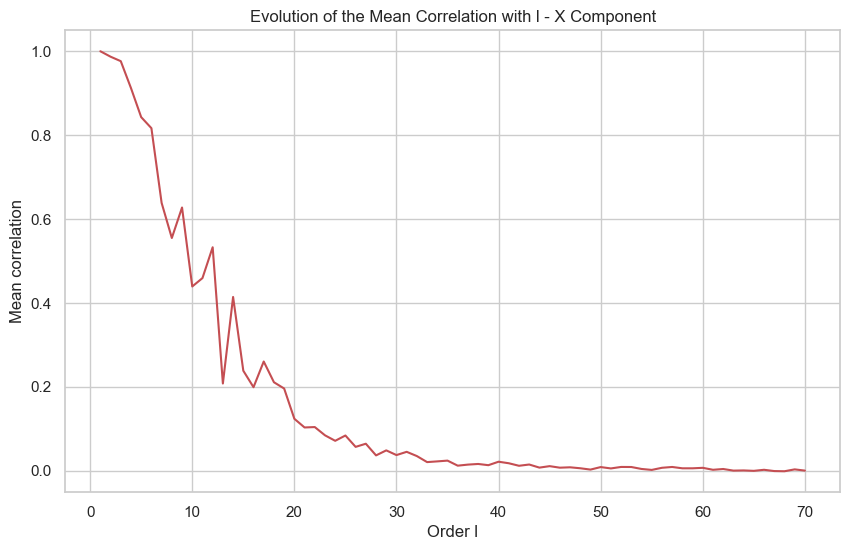

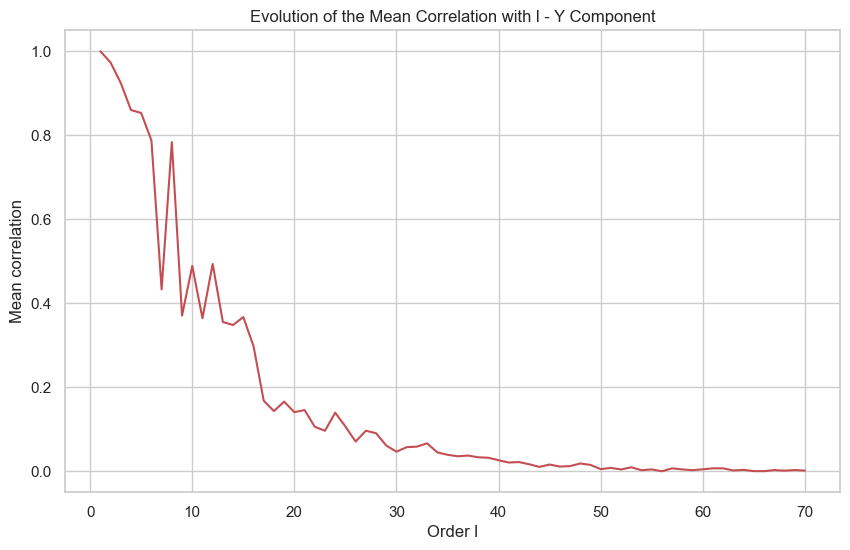

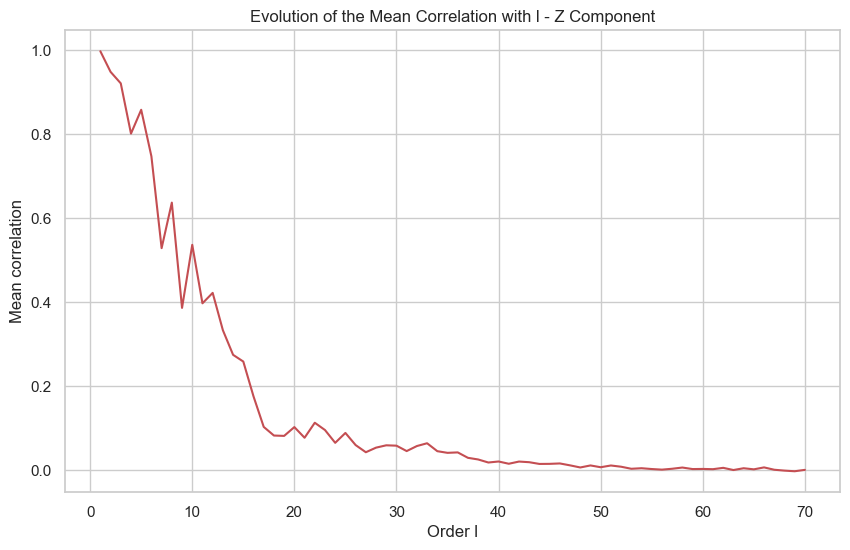

In [43]:
plt.figure(figsize=(10,6))
plt.plot(range(1,lmax+1), np.array(mean_correlations).T[0], '-r')
plt.xlabel('Order l')
plt.ylabel("Mean correlation")
plt.title("Evolution of the Mean Correlation with l - X Component")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1,lmax+1), np.array(mean_correlations).T[1], '-r')
plt.xlabel('Order l')
plt.ylabel("Mean correlation")
plt.title("Evolution of the Mean Correlation with l - Y Component")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1,lmax+1), np.array(mean_correlations).T[2], '-r')
plt.xlabel('Order l')
plt.ylabel("Mean correlation")
plt.title("Evolution of the Mean Correlation with l - Z Component")
plt.grid(True)
plt.show()

In [44]:
def plot_correlation_heatmap(correlations, l,coord):
    if coord=="x":
        c=0
    if coord=="y":
        c=1
    if coord=="z":
        c=2
    n = n_subjects
    matrix = np.ones((n, n))
    k = 0
    for i in range(n):
        for j in range(i+1, n):
            matrix[i,j] = correlations[l][k][c]
            matrix[j,i] = correlations[l][k][c]
            k += 1
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap='coolwarm', center=0)
    plt.title(f'l = {l}')
    plt.show()

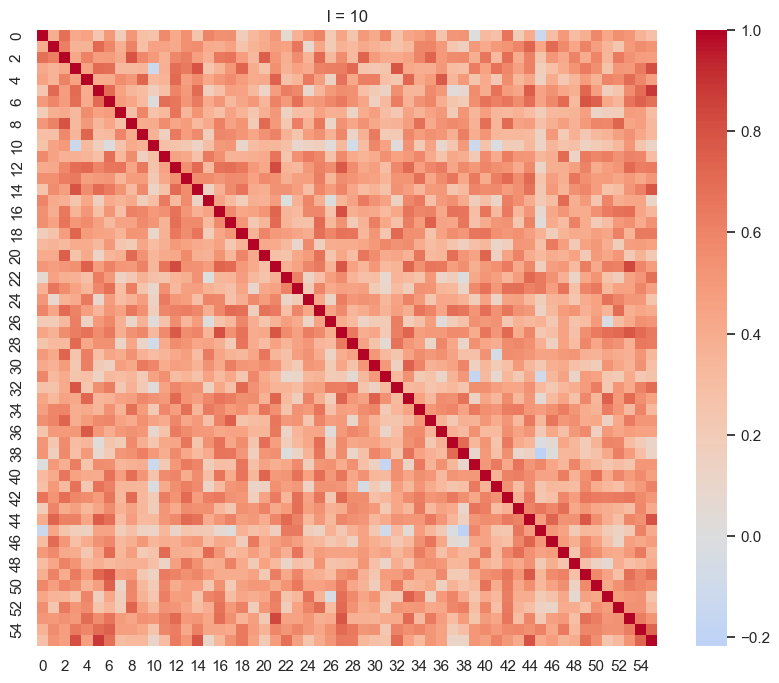

In [46]:
plot_correlation_heatmap(correlations, 10, "x")